In [1]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.stats import ttest_ind,ttest_rel
from scipy import stats,signal
import matplotlib.pyplot as plt

import seaborn as sns

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import platform
import os
import pandas as pd

import imageio

# add the top level directory to allow it to be imported
import sys
sys.path.append(os.path.split(os.getcwd())[0])
from utilities import plotting_utilities
from utilities import helper_functions

from visual_behavior_research.projects.tbd.session import Session

import visual_behavior_research.projects.tbd.utilities as tbdu
from visual_behavior_research.projects.tbd.Inscopix.series import SeriesCellSet
import visual_behavior_research.plotting as vbp
import visual_behavior_research.plotting.dro_plots as pf
import visual_behavior_research.utilities as vbu

from visual_behavior_research.projects.tbd.identify_repeat_rois import Repeat_ROI_Identifier

import isx
from visual_behavior_research.projects.tbd.Inscopix.pipeline import make_cell_map,plot_cell_map

from visual_behavior.translator.foraging import data_to_change_detection_core
from visual_behavior.translator.core import create_extended_dataframe

pd.set_option('display.max_columns', 500)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2

/home/dougo/.conda/envs/isxenv/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
window_size=1.5 # number of seconds before/after each stimulus event over which to integrate activity for the purpose of calling a cell 'responsive'
significance_level = 0.05 # level at which to declare a response 'significant'

In [3]:
data_summary = tbdu.get_data_inventory()
mice_table = tbdu.get_db_table('mice')
data_summary.head()

,id,basepath,behavior_stage,folder,genotype,good_behavior,good_for_analysis,good_neural_data,good_sync,manually_checked,mouse_id,notes,problem,problem_description,processed,running_data,verified_files_present,size(gb),experiment_type,single_cell_plots_made,single_cell_images_made,number_accepted_cells,full_path,recording_date,processing_date,summarized
0,0,//olsenlab1/data/endoscope_imaging,autoreward,2018.03.07_M332849_DoC_day1_autoreward,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,yes,yes,yes,yes,0,M332849,None,1,Not organized into 10 minute chunks,0.0,yes,None,74.790761,change_detection,None,None,NaN,//olsenlab1/data/endoscope_imaging/M332849/201...,2018-03-07 15:16:45.876000,2018-12-15 15:53:28.984200001-08:00,None
1,1,//olsenlab1/data/endoscope_imaging,static_grating,2018.03.09_M332849_DoC_day2,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,no,no,yes,yes,1,M332849,None,0,None,1.0,yes,None,151.789864,change_detection,True,True,45.0,//olsenlab1/data/endoscope_imaging/M332849/201...,2018-03-09 11:27:50.579000,2018-07-25 12:41:22.762362242-07:00,True
2,2,//olsenlab1/data/endoscope_imaging,static_grating,2018.03.13_M332849_DoC_day4,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,yes,yes,yes,yes,1,M332849,None,0,None,1.0,yes,None,134.175156,change_detection,True,True,64.0,//olsenlab1/data/endoscope_imaging/M332849/201...,2018-03-13 11:26:45.003000,2018-07-20 10:57:53.647888899-07:00,True
3,3,//olsenlab1/data/endoscope_imaging,natural_images,2018.03.30_M332849_DoC_day9,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,yes,yes,yes,yes,1,M332849,None,0,Note: more dead cells in forcus this day,1.0,yes,None,146.164498,change_detection,True,True,57.0,//olsenlab1/data/endoscope_imaging/M332849/201...,2018-03-30 13:53:41.511000,2018-07-25 13:48:01.009045124-07:00,True
4,4,//olsenlab1/data/endoscope_imaging,natural_images,2018.04.3_M332849_DoC_day11,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,no,no,yes,no,1,M332849,None,0,None,1.0,yes,None,144.396109,change_detection,True,True,108.0,//olsenlab1/data/endoscope_imaging/M332849/201...,2018-04-03 13:20:29.101000,2018-07-25 13:59:23.514958143-07:00,True


In [4]:
def get_gender(mouse_id):
    mouse_info = vbu.query_labtracks(mouse_id)
    return mouse_info['sex']

In [5]:
last_sessions = pd.DataFrame(data_summary.query('good_for_analysis == "yes"').groupby('mouse_id')['recording_date'].max()).reset_index() # last session for every mouse
sessions_to_analyze = last_sessions.merge(
    data_summary,
    left_on=['mouse_id','recording_date'],
    right_on=['mouse_id','recording_date'],
)
sessions_to_analyze['sex'] = sessions_to_analyze['mouse_id'].map(lambda mid:get_gender(mid.lstrip('M')))
sessions_to_analyze = sessions_to_analyze.merge(mice_table[['mouse_id','anterior_or_posterior', 'AP_coord', 'ML_coord', 'DV_coord']],on='mouse_id')
sessions_to_analyze = sessions_to_analyze.query('anterior_or_posterior == "anterior"')
sessions_to_analyze

,mouse_id,recording_date,id,basepath,behavior_stage,folder,genotype,good_behavior,good_for_analysis,good_neural_data,good_sync,manually_checked,notes,problem,problem_description,processed,running_data,verified_files_present,size(gb),experiment_type,single_cell_plots_made,single_cell_images_made,number_accepted_cells,full_path,processing_date,summarized,sex,anterior_or_posterior,AP_coord,ML_coord,DV_coord
0,M332849,2018-06-14 12:44:33.658000,12,//olsenlab1/data/endoscope_imaging,natural_images,2018.06.14_M332849_DoC_day23,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,yes,yes,yes,no,1,None,0,None,1.0,yes,None,146.340312,change_detection,True,True,126.0,//olsenlab1/data/endoscope_imaging/M332849/201...,2018-07-26 12:11:01.983524799-07:00,True,M,anterior,1.5,3.125,2.5
1,M348126,2018-06-13 13:47:38.463000,29,//olsenlab1/data/endoscope_imaging,natural_images,2018.06.13_M348126_DoC_Day20,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai94(TITL-...,yes,yes,yes,no,1,None,0,None,1.0,yes,None,147.288604,change_detection,True,True,103.0,//olsenlab1/data/endoscope_imaging/M348126/201...,2018-07-26 18:15:45.828682184-07:00,True,F,anterior,1.5,2.625,2.5
2,M351181,2018-03-14 14:32:15.328000,37,//olsenlab1/data/endoscope_imaging,natural_images,2018.03.14__M351181_DoC_day8,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai94(TITL-...,yes,yes,yes,yes,1,None,0,None,1.0,yes,None,147.362931,change_detection,True,True,127.0,//olsenlab1/data/endoscope_imaging/M351181/201...,2018-07-26 18:59:36.293976068-07:00,True,F,anterior,1.5,2.625,2.5
3,M397408,2018-11-01 11:40:14.487000,153,//olsenlab1/data/endoscope_imaging,None,20181101_M397408_DoC_day5,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,None,yes,None,None,0,,0,,1.0,None,None,153.154207,change_detection,True,True,29.0,//olsenlab1/data/endoscope_imaging/M397408/201...,2019-01-22 01:32:10.700291872-08:00,True,F,anterior,1.5,2.625,2.5


In [6]:
sessions_to_analyze['sex'] = sessions_to_analyze['mouse_id'].map(lambda mid:get_gender(mid.lstrip('M')))
sessions_to_analyze = sessions_to_analyze.merge(mice_table[['mouse_id','anterior_or_posterior', 'AP_coord', 'ML_coord', 'DV_coord']],on='mouse_id')

In [7]:
data = {}

folders = sessions_to_analyze['folder']

for foldername in folders:
    print('on folder {}'.format(foldername))

    row = data_summary[data_summary['folder']==foldername].iloc[0]

    mouse_id = row['mouse_id']
    path = os.path.join(row['basepath'],row['mouse_id'],row['folder'])

    data[foldername]=pd.read_pickle(os.path.join(path,'cached_data_2019.10.04.pkl'))

    data[foldername]['session'] = Session(
        data[foldername]['path'], 
        load_cached_traces_table = True,
        behavior_pkl_filename = helper_functions.which_pkl(data[foldername]['filename_dict'])
    )

on folder 2018.06.14_M332849_DoC_day23
filename = //olsenlab1/data/endoscope_imaging/M332849/2018.06.14_M332849_DoC_day23/additional_data/180614134458-task=DoC_NaturalImages_CAMMatched_n=8_stage=natural_images_drop_reward_mouse=M332849.pkl
on folder 2018.06.13_M348126_DoC_Day20
filename = //olsenlab1/data/endoscope_imaging/M348126/2018.06.13_M348126_DoC_Day20/additional_data/180613144805-task=DoC_NaturalImages_CAMMatched_n=8_stage=natural_images_drop_reward_mouse=M348126.pkl
on folder 2018.03.14__M351181_DoC_day8
filename = //olsenlab1/data/endoscope_imaging/M351181/2018.03.14__M351181_DoC_day8/additional_data/180314153237-task=DoC_NaturalImages_CAMMatched_n=8_stage=natural_images_drop_reward_mouse=M351181.pkl
on folder 20181101_M397408_DoC_day5
filename = //olsenlab1/data/endoscope_imaging/M397408/20181101_M397408_DoC_day5/additional_data/181101124039-task=DoC_NaturalImages_CAMMatched_n=8_stage=natural_images_mouse=M397408.pkl


In [8]:
foldernames = list(data.keys())
for i,foldername in enumerate(foldernames):
    print(i,foldername)

0 2018.06.14_M332849_DoC_day23
1 2018.06.13_M348126_DoC_Day20
2 2018.03.14__M351181_DoC_day8
3 20181101_M397408_DoC_day5


In [9]:
mice = data_summary[data_summary.good_for_analysis=='yes'].mouse_id.unique()
mice

array(['M332849', 'M348126', 'M351181', 'M397408', 'M423780'],
      dtype=object)

## build out responsiveness summary

In [10]:
frame_before=200
frame_after=200

cell_lookup = []

event_types = ['hit','miss','fa','cr']
    
mean_response_dfs = {event_type:pd.DataFrame({'t':np.linspace(-frame_before*0.05,(frame_after-1)*0.05,frame_before+frame_after)}) for event_type in event_types}

responsiveness_summary_all = []
tidy_response_df = []
for ii,foldername in enumerate(foldernames):
    print('on {} of {}'.format(ii,len(foldernames)))
    mouse_id = data_summary[data_summary['folder']==foldername].mouse_id.iloc[0]

#     data_dict = data[foldername]
    event_dict = {}
    session = data[foldername]['session']
    trials = session.behavior_core_data['extended_trials']
    traces_zs = session.filtered_traces
    rewards = data[foldername]['core_data']['rewards']

    licks = data[foldername]['core_data']['licks']
    licks['nearest_F_frame'] = licks['frame'].map(lambda x:helper_functions.get_F_frame(int(x),data[foldername]['sync_data']))
    licks['time_since_last_lick'] = licks['time'] - licks['time'].shift()
    licks['nearest_reward']=licks['time'].map(lambda x:helper_functions.nearest_reward(x,rewards))

    vs = data[foldername]['core_data']['visual_stimuli']
    # rebase time on sync (not sure why this isn't happening by default!)
    vs['time'] = data[foldername]['sync_data']['behavior_vsync'][vs['frame'].values]
    vs['nearest_lick'] = vs['time'].map(lambda x:helper_functions.nearest_lick(x,licks))
    vs['change'] = vs['image_name'] != vs['image_name'].shift()
    vs['nearest_F_frame'] = vs['frame'].map(lambda x:helper_functions.get_F_frame(int(x),data[foldername]['sync_data']))

    hit_licks = licks[
        (licks['nearest_reward']<0.1)
        &(licks['time_since_last_lick']>2.25)
        &(~np.isnan(licks['nearest_F_frame']))
    ]
    
    event_dict['hit_events'] = []
    for idx,row in hit_licks.iterrows():
        lick_time = row['time']
        event_dict['hit_events'].append(vs.query('time < @lick_time')['nearest_F_frame'].iloc[-1])

    fa_licks = licks[
        (licks['nearest_reward']>2)
        &(licks['time_since_last_lick']>2.25)
        &(~np.isnan(licks['nearest_F_frame']))
    ]
    
    event_dict['fa_events'] = []
    for idx,row in fa_licks.iterrows():
        lick_time = row['time']
        event_dict['fa_events'].append(vs.query('time < @lick_time')['nearest_F_frame'].iloc[-1])

    event_dict['miss_events'] = trials.query('response_type == "MISS"')['change_frame'].map(lambda x:helper_functions.get_F_frame(int(x),data[foldername]['sync_data']))
    event_dict['miss_events'] = event_dict['miss_events'][pd.notnull(event_dict['miss_events'])]

    cr_events = vs.query('change == False and nearest_lick > 2')
    event_dict['cr_events'] = cr_events.sample(min(100,len(cr_events)),random_state=0)['nearest_F_frame'] #get a random sample of correct rejections (non-change flashes without nearby licks)
    event_dict['cr_events'] = event_dict['cr_events'][pd.notnull(event_dict['cr_events'])]

    # set the event_dict as an attribute of the session:
    data[foldername]['session'].event_dict = event_dict
    
    # set responsiveness_data as an attribute of the session:
    session.responsiveness_data = helper_functions.get_responsiveness_data(session, window_size=window_size)
    
    data[foldername]['responsiveness_summary'] = helper_functions.build_responsiveness_summary(session)
    data[foldername]['responsiveness_summary']['foldername'] = foldername
    responsiveness_summary_all.append(data[foldername]['responsiveness_summary'])

    # build out datatframes containiing mean resonses for every cell and every event type
    for cell_id in session.filtered_cell_IDs:
        for condition in ['hit','miss','fa','cr']:
            events = event_dict['{}_events'.format(condition)]
            dat = helper_functions.get_responses(session,cell_id,events,frame_before=frame_before,frame_after=frame_after)
            mean_response_dfs[condition]['{}_{}'.format(foldername,cell_id)] = dat['trace_mean']
            for ii in range(np.shape(dat['all_traces'])[0]):
                df = pd.DataFrame({'t':dat['t'],'z_scored_activity':dat['all_traces'][ii]})
                df['condition'] = condition
                df['repeat_number'] = ii
                df['cell_id'] = cell_id
                df['experiment'] = foldername
                tidy_response_df.append(df)

#     print('failed on {}'.format(foldername))
#     print('e')
tidy_response_df = pd.concat(tidy_response_df)
responsiveness_summary_all = pd.concat(responsiveness_summary_all)
responsiveness_summary_all['integral_change_magnitude'] = responsiveness_summary_all['post_stim_integral_mean'] - responsiveness_summary_all['pre_stim_integral_mean']
responsiveness_summary_all['mean_change_magnitude'] = responsiveness_summary_all['post_stim_mean_all'] - responsiveness_summary_all['pre_stim_mean_all']

on 0 of 4
on 1 of 4
on 2 of 4
on 3 of 4


In [11]:
responsiveness_summary_all.to_csv('active_responsiveness_summary.csv', index=False)

In [12]:
responsiveness_summary_all

,cell_id,condition,number_of_trials,pre_stim_integral_mean,post_stim_integral_mean,p-value_on_integrals,direction_of_effect_on_integrals,pre_stim_mean_all,post_stim_mean_all,p-value_on_means,direction_of_effect_on_means,foldername,integral_change_magnitude,mean_change_magnitude
0,C000,hit,52,1.160885,-18.435498,NaN,-1.0,0.040479,-0.642261,NaN,-1.0,2018.06.14_M332849_DoC_day23,-19.596383,-0.682740
1,C000,miss,67,1.160885,0.020795,NaN,-1.0,0.040479,0.003840,NaN,-1.0,2018.06.14_M332849_DoC_day23,-1.140089,-0.036639
2,C000,fa,194,1.160885,1.075905,NaN,-1.0,0.040479,0.038185,NaN,-1.0,2018.06.14_M332849_DoC_day23,-0.084979,-0.002294
3,C000,cr,71,1.160885,1.642248,NaN,1.0,0.040479,0.057217,NaN,1.0,2018.06.14_M332849_DoC_day23,0.481363,0.016738
4,C001,hit,52,-0.062618,-1.058261,NaN,-1.0,-0.001701,-0.036923,NaN,-1.0,2018.06.14_M332849_DoC_day23,-0.995642,-0.035222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,C158,cr,66,-1.847343,-5.996310,NaN,-1.0,-0.063373,-0.206745,NaN,-1.0,20181101_M397408_DoC_day5,-4.148967,-0.143372
112,C165,hit,51,3.069555,-4.038393,NaN,-1.0,0.103010,-0.146150,NaN,-1.0,20181101_M397408_DoC_day5,-7.107948,-0.249160
113,C165,miss,40,3.069555,1.763943,NaN,-1.0,0.103010,0.062907,NaN,-1.0,20181101_M397408_DoC_day5,-1.305612,-0.040103
114,C165,fa,301,3.069555,-3.914768,NaN,-1.0,0.103010,-0.133257,NaN,-1.0,20181101_M397408_DoC_day5,-6.984323,-0.236268


## plot responsiveness histograms

In [13]:
session.responsiveness_data

,cell_id,stim_condition,presentation_number,pre_stim_integral,post_stim_integral,pre_stim_mean,post_stim_mean
0,C000,hit,0,-0.999124,1.556368,-0.036522,0.038018
1,C000,hit,1,-3.581559,-3.926049,-0.130770,-0.137950
2,C000,hit,2,-1.407774,-0.495931,-0.049635,-0.012697
3,C000,hit,3,-1.011851,-2.266538,-0.032345,-0.075054
4,C000,hit,4,-4.978111,-5.238003,-0.177328,-0.177171
...,...,...,...,...,...,...,...
13277,C165,cr,61,-4.852075,9.464952,-0.161489,0.323116
13278,C165,cr,62,-0.432681,-1.323864,-0.040642,-0.024849
13279,C165,cr,63,-16.866665,-9.890396,-0.585206,-0.303589
13280,C165,cr,64,-2.799378,1.245066,-0.083110,0.046616


In [14]:
def plot_mod_index_hist(index_vals, significant, ax, bin_edges=np.arange(-2,2,0.1)):
    '''
    index_vals (array of float): values of the index you want to plot
    significant (array of bool): whether each index val is significant or not
    '''
    
    ax.hist([index_vals[significant],index_vals[~significant]], 
             color=['k','darkgrey'], edgecolor='None', stacked=True, 
             bins=bin_edges, rwidth=0.8, normed=True)


def plot_response_histograms(ax=None, significance_threshold=0.05):
    '''
    ax should be a 1x4 array of axis handles if passed
    '''
    if ax is None:
        fig,ax=plt.subplots(1,4,figsize=(20,5),sharex=True, sharey=False)
        
    titles = ['Hits','False Alarms','Misses','Correct Rejects']
    for ii,condition in enumerate(['hit','fa','miss','cr']):
        magnitude = responsiveness_summary_all.query('condition == @condition')['mean_change_magnitude']
#         magnitude = responsiveness_summary_all.query('condition == @condition')['integral_change_magnitude']
        significant = responsiveness_summary_all.query('condition == @condition')['p-value_on_means'] < significance_threshold
        plot_mod_index_hist(
            magnitude,
            significant,
            ax[ii]
        )

        axins = inset_axes(ax[ii], width="40%", height="40%", loc=1)

        ax[ii].set_title('{}\nfraction modulated cells: {:0.3f}'.format(titles[ii],significant.mean()))

    #     ax[ii].axvline(0,linestyle=':',color='k',)
        axins.pie(
            [significant.sum(),len(significant)-significant.sum()],
            colors=['black','gray'],
            labels=['','']
        )
        ax[ii].set_xlabel('change in mean (z-score)', fontsize=16)
        ax[ii].set_yticks([])
    ax[0].set_ylabel('fraction')
    sns.despine()

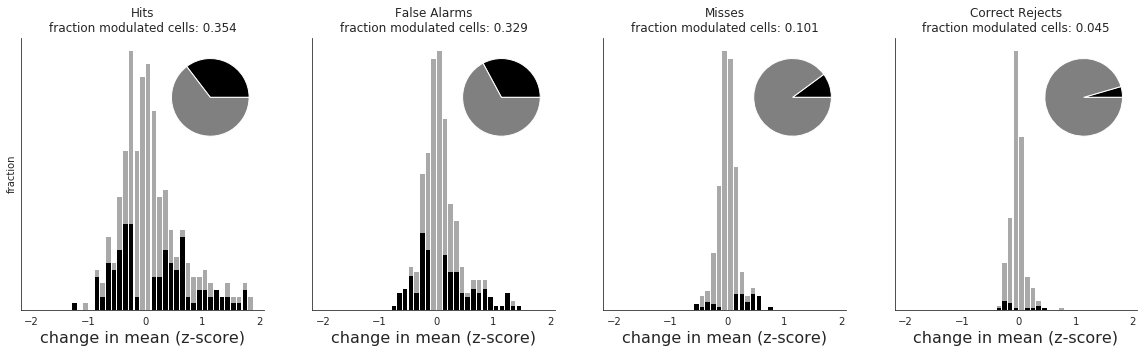

In [15]:
plot_response_histograms(ax=None, significance_threshold=0.05)

## plot response heatmaps

In [16]:
def plot_heatmaps(ax=None, order_by_hits=False):
    if ax is None:
        fig,ax=plt.subplots(1,4,figsize=(12,5))

    tmin = mean_response_dfs['hit']['t'].min()
    tmax = mean_response_dfs['hit']['t'].max()

    titles = ['Hits','False Alarms','Misses','Correct Rejects']
    event_type_order = ['hit','fa','miss','cr']
    for ii,event_type in enumerate(event_type_order):
        idx_for_mean = mean_response_dfs[event_type][['t']].query('t>0 and t<1').index
        if order_by_hits == False:
#             col_order = mean_response_dfs[event_type].drop(columns=['t']).loc[idx_for_mean].mean(axis=0).dropna().sort_values(ascending=False).index
            responsiveness_summary_all.query('condition == @event_type').sort_values(by='mean_change_magnitude',ascending=False)
            col_order = []
            for idx,row in responsiveness_summary_all.query('condition == "hit"').sort_values(by='mean_change_magnitude',ascending=False).iterrows():
                col_order.append(row['foldername']+'_'+row['cell_id'])
        else:
#             col_order = mean_response_dfs['hit'].drop(columns=['t']).loc[idx_for_mean].mean(axis=0).dropna().sort_values(ascending=False).index  
            responsiveness_summary_all.query('condition == @event_type').sort_values(by='mean_change_magnitude',ascending=False)
            col_order = []
            for idx,row in responsiveness_summary_all.query('condition == "hit"').sort_values(by='mean_change_magnitude',ascending=False).iterrows():
                col_order.append(row['foldername']+'_'+row['cell_id'])
        arr = mean_response_dfs[event_type][col_order].values

        ax[ii].imshow(
            arr.T,
            clim=[-5,5],
            cmap='seismic',
            aspect='auto',
            extent=(tmin,tmax,0,len(col_order)),
            interpolation='none'
        )

        ax[ii].set_title(titles[ii])
        ax[ii].set_yticks([])
        ax[ii].set_xticks([0,2,4])
        ax[ii].set_xlabel('time from\nevent (s)')
        ax[ii].axvline(0,color='black',alpha=0.5,linewidth=3)

        ax[ii].set_xlim(-1,5)

      

In [17]:
responsiveness_summary_all.query('condition == "hit"').sort_values(by='mean_change_magnitude',ascending=False)
col_order = []
for idx,row in responsiveness_summary_all.query('condition == "hit"').sort_values(by='mean_change_magnitude',ascending=False).iterrows():
    col_order.append(row['foldername']+'_'+row['cell_id'])

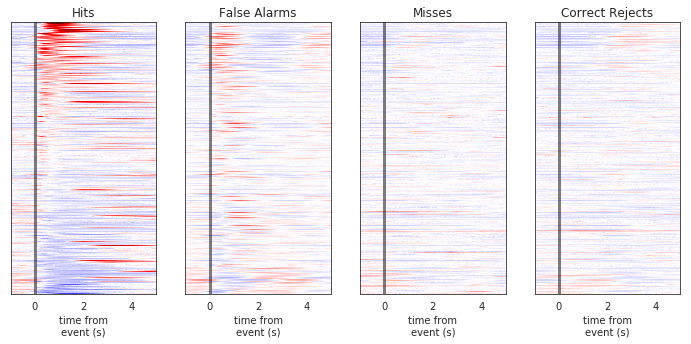

In [18]:
plot_heatmaps(ax=None, order_by_hits=True)

In [19]:
responsiveness_summary_all

,cell_id,condition,number_of_trials,pre_stim_integral_mean,post_stim_integral_mean,p-value_on_integrals,direction_of_effect_on_integrals,pre_stim_mean_all,post_stim_mean_all,p-value_on_means,direction_of_effect_on_means,foldername,integral_change_magnitude,mean_change_magnitude
0,C000,hit,52,1.160885,-18.435498,NaN,-1.0,0.040479,-0.642261,NaN,-1.0,2018.06.14_M332849_DoC_day23,-19.596383,-0.682740
1,C000,miss,67,1.160885,0.020795,NaN,-1.0,0.040479,0.003840,NaN,-1.0,2018.06.14_M332849_DoC_day23,-1.140089,-0.036639
2,C000,fa,194,1.160885,1.075905,NaN,-1.0,0.040479,0.038185,NaN,-1.0,2018.06.14_M332849_DoC_day23,-0.084979,-0.002294
3,C000,cr,71,1.160885,1.642248,NaN,1.0,0.040479,0.057217,NaN,1.0,2018.06.14_M332849_DoC_day23,0.481363,0.016738
4,C001,hit,52,-0.062618,-1.058261,NaN,-1.0,-0.001701,-0.036923,NaN,-1.0,2018.06.14_M332849_DoC_day23,-0.995642,-0.035222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,C158,cr,66,-1.847343,-5.996310,NaN,-1.0,-0.063373,-0.206745,NaN,-1.0,20181101_M397408_DoC_day5,-4.148967,-0.143372
112,C165,hit,51,3.069555,-4.038393,NaN,-1.0,0.103010,-0.146150,NaN,-1.0,20181101_M397408_DoC_day5,-7.107948,-0.249160
113,C165,miss,40,3.069555,1.763943,NaN,-1.0,0.103010,0.062907,NaN,-1.0,20181101_M397408_DoC_day5,-1.305612,-0.040103
114,C165,fa,301,3.069555,-3.914768,NaN,-1.0,0.103010,-0.133257,NaN,-1.0,20181101_M397408_DoC_day5,-6.984323,-0.236268


## plot example cells

In [20]:
facilitated = responsiveness_summary_all[
    (responsiveness_summary_all['condition'] == 'hit')
    &(responsiveness_summary_all['p-value_on_means'] < significance_level)
    &(responsiveness_summary_all['direction_of_effect_on_means'] > 0)
    &(responsiveness_summary_all['mean_change_magnitude'] > 0.75)
].reset_index()
facilitated.sample(5,random_state=0)

,index,cell_id,condition,number_of_trials,pre_stim_integral_mean,post_stim_integral_mean,p-value_on_integrals,direction_of_effect_on_integrals,pre_stim_mean_all,post_stim_mean_all,p-value_on_means,direction_of_effect_on_means,foldername,integral_change_magnitude,mean_change_magnitude
11,276,C086,hit,48,-10.665674,21.874361,5.126723e-51,1.0,-0.355091,0.743950,3.698552e-49,1.0,2018.06.13_M348126_DoC_Day20,32.540035,1.099041
10,264,C082,hit,48,-7.769906,23.387677,2.045040e-39,1.0,-0.259140,0.790693,3.684199e-38,1.0,2018.06.13_M348126_DoC_Day20,31.157582,1.049833
21,260,C076,hit,48,-4.673464,24.235141,7.413158e-14,1.0,-0.160571,0.810740,2.015929e-13,1.0,2018.03.14__M351181_DoC_day8,28.908605,0.971312
14,344,C110,hit,48,-7.993960,27.110599,4.738381e-17,1.0,-0.271970,0.930768,3.421360e-17,1.0,2018.06.13_M348126_DoC_Day20,35.104559,1.202737
20,232,C065,hit,48,-3.165340,33.673779,7.058033e-25,1.0,-0.109175,1.135608,1.710078e-24,1.0,2018.03.14__M351181_DoC_day8,36.839119,1.244783


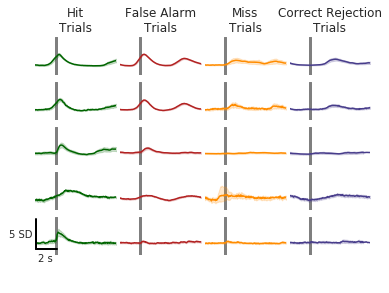

In [21]:
to_plot = facilitated.sample(5,random_state=0)
fig,ax=plt.subplots(len(to_plot),4,figsize=(6,4),sharex=True,sharey=True)

helper_functions.plot_examples(to_plot, data, ax)

In [22]:
suppressed = responsiveness_summary_all[
    (responsiveness_summary_all['condition'] == 'hit')
    &(responsiveness_summary_all['p-value_on_means'] < significance_level)
    &(responsiveness_summary_all['direction_of_effect_on_means'] < 0)
    &(responsiveness_summary_all['mean_change_magnitude'] < -0.25)
].reset_index()
suppressed.sample(5,random_state=0)

,index,cell_id,condition,number_of_trials,pre_stim_integral_mean,post_stim_integral_mean,p-value_on_integrals,direction_of_effect_on_integrals,pre_stim_mean_all,post_stim_mean_all,p-value_on_means,direction_of_effect_on_means,foldername,integral_change_magnitude,mean_change_magnitude
45,284,C088,hit,48,1.931635,-9.516953,1.080083e-02,-1.0,0.065964,-0.328683,1.056167e-02,-1.0,2018.03.14__M351181_DoC_day8,-11.448587,-0.394647
33,328,C102,hit,48,13.600239,-5.341473,3.739080e-07,-1.0,0.461252,-0.179747,4.356704e-07,-1.0,2018.06.13_M348126_DoC_Day20,-18.941712,-0.640999
40,372,C145,hit,48,-1.105484,-11.837277,1.382404e-03,-1.0,-0.038839,-0.402600,1.612730e-03,-1.0,2018.06.13_M348126_DoC_Day20,-10.731794,-0.363761
26,244,C075,hit,48,8.594353,-15.385001,1.773459e-09,-1.0,0.290252,-0.527331,1.927716e-09,-1.0,2018.06.13_M348126_DoC_Day20,-23.979354,-0.817584
11,100,C029,hit,48,-3.426692,-11.223949,2.443699e-03,-1.0,-0.115527,-0.387596,2.149357e-03,-1.0,2018.06.13_M348126_DoC_Day20,-7.797257,-0.272069


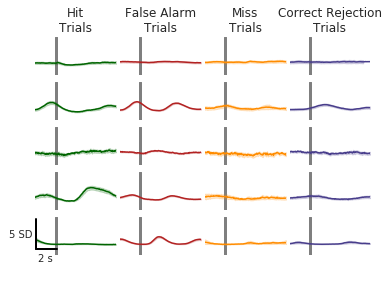

In [23]:
to_plot = suppressed.sample(5,random_state=0)
fig,ax=plt.subplots(len(to_plot),4,figsize=(6,4),sharex=True,sharey=True)

helper_functions.plot_examples(to_plot, data, ax)

## show schematics

In [24]:
def show_schematic(filename, ax=None,):
    if ax is None:
        fig,ax=plt.subplots()
    image = imageio.imread(filename)
    ax.imshow(image,interpolation='nearest')
    ax.axis('off')

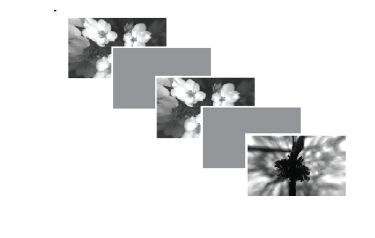

In [25]:
show_schematic('flashing_image_schematic.png')

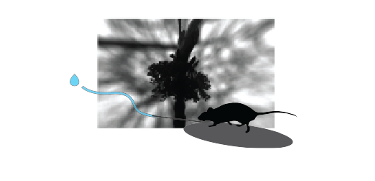

In [26]:
show_schematic('mouse_schematic.png')

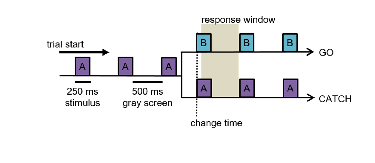

In [27]:
show_schematic('task_schematic.png')

# Final Figure

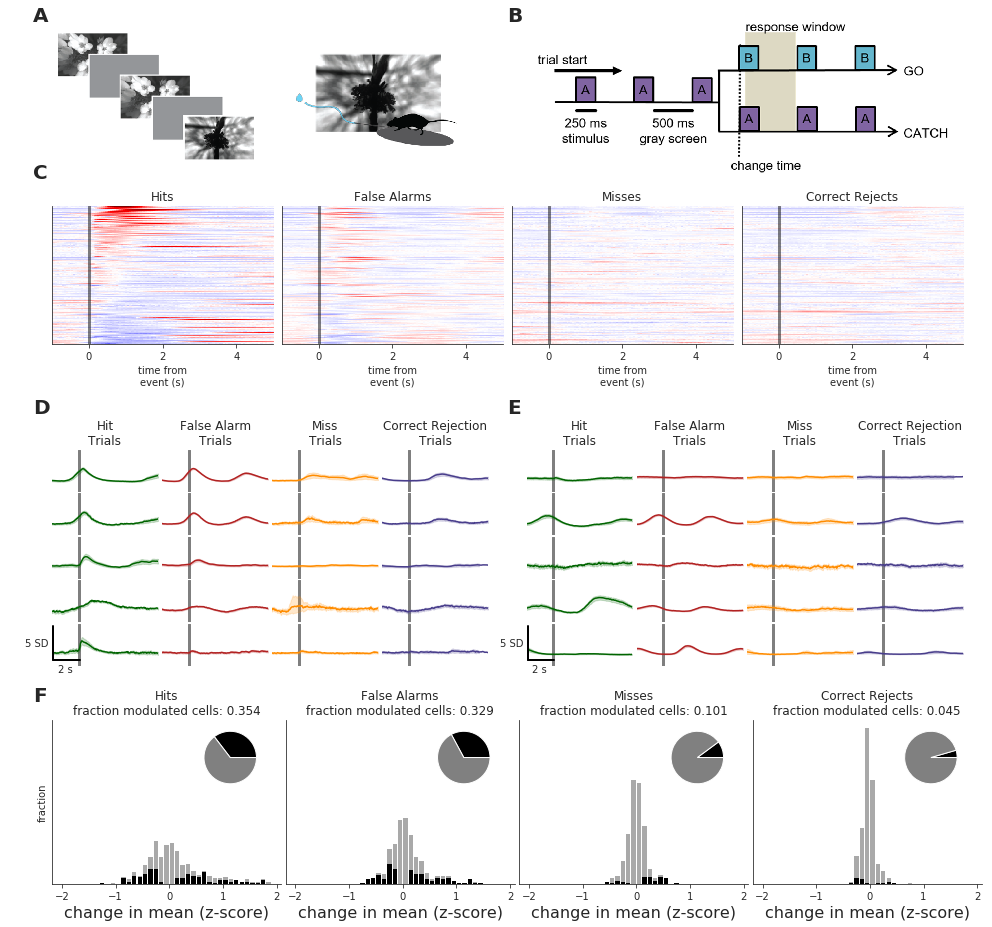

In [28]:
save_fig = True

figsize=(2*8.5,2*8)
figure_3 = plt.figure(figsize=figsize)
n_example_cells = 5
axes = {
    'A1':plotting_utilities.placeAxesOnGrid(figure_3, xspan=[0.0,0.25], yspan=[0,0.2]),
    'A2':plotting_utilities.placeAxesOnGrid(figure_3, xspan=[0.25,0.5], yspan=[0,0.2]),
    'B':plotting_utilities.placeAxesOnGrid(figure_3,  xspan=[0.5,1],    yspan=[0,0.2]),
    'C':plotting_utilities.placeAxesOnGrid(figure_3,  xspan=[0.02,0.98],   yspan=[0.22,0.38], dim=[1,4], sharex=True, sharey=True, wspace=0.04),
    'D':plotting_utilities.placeAxesOnGrid(figure_3,  xspan=[0.02,0.48],   yspan=[0.5,0.75], dim=[n_example_cells,4], sharex=False, sharey=True, wspace=0.04, hspace=0.04),
    'E':plotting_utilities.placeAxesOnGrid(figure_3,  xspan=[0.52,0.98],   yspan=[0.5,0.75], dim=[n_example_cells,4], sharex=False, sharey=True, wspace=0.04, hspace=0.04),
    'F':plotting_utilities.placeAxesOnGrid(figure_3,  xspan=[0.02,1],   yspan=[0.81,1],    dim=[1,4], sharex=True, sharey=True, wspace=0.02),
}
    
show_schematic('flashing_image_schematic.png', ax=axes['A1'])
show_schematic('mouse_schematic.png', ax=axes['A2'])
show_schematic('task_schematic.png', ax=axes['B'])
plot_heatmaps(ax=axes['C'], order_by_hits=True)

helper_functions.plot_examples(facilitated.sample(5,random_state=0), data, ax=axes['D'])
helper_functions.plot_examples(suppressed.sample(5,random_state=0), data, ax=axes['E'])

plot_response_histograms(ax=axes['F'], significance_threshold=0.05)

# add labels
labels = [
    {'label_text':'A', 'xpos':0,   'ypos':0.0},
    {'label_text':'B', 'xpos':0.5, 'ypos':0.0},
    {'label_text':'C', 'xpos':0,   'ypos':0.18},
    {'label_text':'D', 'xpos':0,   'ypos':0.45},
    {'label_text':'E', 'xpos':0.5, 'ypos':0.45},
    {'label_text':'F', 'xpos':0,   'ypos':0.78},
]
for label in labels:
    plotting_utilities.add_label(
        figure_3,
        label_text = label['label_text'],
        xpos = label['xpos'],
        ypos = label['ypos'],
        fontsize=20,
        weight="bold"
    )

if save_fig:
    plotting_utilities.save_figure(figure_3, fname='figure_3', formats=['.png','.pdf'], size=figsize, dpi=500)

## to do on this figure:
* explore only one heatmap (individually sorted)
* show mean and standard error (not individual traces) on example plots
* why is there a hit-facilitated cell in F?
* be consistent in x-label of histogram between 2D and 3G
* link C to E/F - label more clearly and maybe number rows in heatmap

# followup for figure 4:
* show how the sign of the hit response maps to location in space.
* Does the same spatial intermingling in FOV hold?
* Is there a simple metric for spatial segregation (or lack therof?). 
    * pairwise distance within group and across group.

In [29]:
# idx_for_mean = mean_response_dfs['hit'][['t']].query('t>0 and t<1').index
# col_order = mean_response_dfs['hit'].drop(columns=['t']).loc[idx_for_mean].mean(axis=0).dropna().sort_values(ascending=False).index  
# mean_response_dfs['hit'][col_order]

In [30]:
# responsiveness_summary_all

In [31]:
# fig,ax=plt.subplots()
# for ii,col in enumerate(col_order):
#     folder = col.split('_C')[0]
#     cell = 'C' + col.split('_C')[1]
#     res = responsiveness_summary_all.query('foldername == @folder and cell_id == @cell').iloc[0]
#     ax.plot(ii,res['post_stim_integral_mean']/res['pre_stim_integral_mean'],'ok')

In [33]:
# responsiveness_summary_all.query('foldername == @folder and cell_id == @cell')

In [32]:
# res['post_stim_integral_mean']/res['pre_stim_integral_mean']

In [34]:
# res['post_stim_integral_mean']
# res['pre_stim_integral_mean']

In [44]:
# res['post_stim_integral_mean']

-24.918344057122642

In [36]:
# fig,ax = plt.subplots()
# ax.plot(
#     mean_response_dfs['hit']['t'],
#     mean_response_dfs['hit'][col]
# )

In [37]:
# fig,ax = plt.subplots(2,4,figsize=(15,10),sharex=True,sharey=True)
# row = 0
# for i in range(-13,-11,1):
#     col_name = col_order[i]
#     folder = col_name.split('_C')[0]
#     cell = 'C' + col_name.split('_C')[1]
    
#     for j,condition in enumerate(['hit','miss','fa','cr']):
#         print(condition)
#         sns.lineplot(
#             data = tidy_response_df.query('experiment == @folder and cell_id == @cell and condition == @condition'),
#             x='t',
#             y='z_scored_activity',
#             hue='repeat_number',
#             ax=ax[row,j],
#             legend=False
#         )
#         ax[row,j].set_title(condition)
# #         break
# #     break
#     row += 1
# ax[row,j].set_xlim(-3,5)

In [38]:
# tidy_response_df.query('experiment == @folder and condition == "fa"')

In [39]:
# fig,ax = plt.subplots()
# ax.plot(
#     data[folder]['session'].filtered_traces['t'],
#     data[folder]['session'].filtered_traces[cell]
# )
# ax.set_xlabel('time')
# ax.set_ylabel('z-scored activity')

In [40]:
# data[folder]['session'].metrics.loc['C140']

In [41]:
# tidy_response_df['experiment'].unique()

In [42]:
# s = data[folder]['session']
# dir(s)

In [43]:
# fig,ax=plt.subplots()
# ax.imshow(s.cell_images['C140'][0])

In [44]:
# fig = go.Figure(data=go.Heatmap(z=s.cell_images['C140'][0]))
# fig.show()

In [45]:
# folder

In [46]:
# len(col_order)

In [47]:
# from plotly.subplots import make_subplots
# import plotly.graph_objects as go

# n_rows = 10
# fig = make_subplots(rows=n_rows, cols=5)
# t = np.sort(tidy_response_df['t'].unique())

# for row,string_to_parse in enumerate(col_order[:n_rows]):
#     print('on row {}'.format(row), end='\r')
#     folder = string_to_parse.split('_C')[0]
#     cell_id = 'C' + string_to_parse.split('_C')[1]
    
#     fig.add_trace(
#         go.Heatmap(z=data[folder]['session'].cell_images[cell_id][0],colorbar=None),
#         row=row+1, col=1
#     )
    
#     for col,condition in enumerate(['hit','miss','fa','cr']):
#         mean_activity = tidy_response_df.query('experiment == @folder and cell_id == @cell_id and condition == @condition').groupby('t').mean()['z_scored_activity'].values
        
#         fig.add_trace(
#             go.Scatter(x=t, y=mean_activity),
#             row=row+1, col=col+2
#         )
# fig.layout.coloraxis.showscale = False

# fig.update_layout(height=300*n_rows, width=1500, title_text="Side By Side Subplots", showlegend=False)
# fig.write_html("/home/dougo/code/dougollerenshaw.github.io/figures_to_share/response_plot_test.html")
# fig.show()

In [48]:
# n_rows = 10
# fig = make_subplots(rows=n_rows, cols=5)
# t = np.sort(tidy_response_df['t'].unique())

# for row,string_to_parse in enumerate(col_order[-n_rows:]):
#     print('on row {}'.format(row), end='\r')
#     folder = string_to_parse.split('_C')[0]
#     cell_id = 'C' + string_to_parse.split('_C')[1]
    
#     fig.add_trace(
#         go.Heatmap(z=data[folder]['session'].cell_images[cell_id][0],colorbar=None),
#         row=row+1, col=1
#     )
    
#     for col,condition in enumerate(['hit','miss','fa','cr']):
#         mean_activity = tidy_response_df.query('experiment == @folder and cell_id == @cell_id and condition == @condition').groupby('t').mean()['z_scored_activity'].values
        
#         fig.add_trace(
#             go.Scatter(x=t, y=mean_activity),
#             row=row+1, col=col+2
#         )
# fig.layout.coloraxis.showscale = False

# fig.update_layout(height=300*n_rows, width=1500, title_text="Side By Side Subplots", showlegend=False)
# fig.write_html("/home/dougo/code/dougollerenshaw.github.io/figures_to_share/response_plot_least_responsive.html")
# fig.show()

In [49]:
# %%time
# mean_activity = tidy_response_df.query('experiment == @folder and cell_id == @cell_id and condition == @condition')# .groupby('t').mean()['z_scored_activity'].values

In [50]:
# colors = {
#     'hit':'darkgreen',
#     'fa':'firebrick',
#     'cr':'DarkSlateBlue',
#     'miss':'DarkOrange'
# }

# n_rows = len(col_order)
# figsize=(12,n_rows)
# fig,ax=plt.subplots(n_rows,4,figsize=figsize, sharey='row')

# t = np.sort(tidy_response_df['t'].unique())
# for row,string_to_parse in enumerate(col_order[:n_rows ]):
#     print('on row {}'.format(row), end='\r')
#     foldername = string_to_parse.split('_C')[0]
#     cell_id = 'C' + string_to_parse.split('_C')[1]
    
#     for col,event in enumerate(['hit','miss','fa','cr']):
        
#         data_dict = data[foldername]
#         session = data_dict['session']
#         events = data_dict['{}_events'.format(event)]
#         dat = fig3_helper_functions.get_responses(session,cell_id,events,frame_before=frame_before,frame_after=frame_after)

#         pf.plot_event_triggered_timeseries(dat,foreground_color=colors[event],ax=ax[row][col])
#         ax[row][col].axvline(0,color='k',alpha=0.5,zorder=-np.inf,linewidth=3)
# #         ax[row][col].set_ylim(-5,15.5)
#         ax[row][col].set_xlim(-2,10)

#         ax[row][col].axis('off')
        
# plotting_utilities.save_figure(fig, fname='/home/dougo/code/dougollerenshaw.github.io/figures_to_share/all_cell_responses', formats=['.png'], size=figsize, dpi=150)

In [51]:
# data_dict.keys()

In [52]:
# data[foldername]['F_events'].keys()

In [53]:
# to_plot = factilitated.sample(5,random_state=2)
# fig,ax=plt.subplots(len(to_plot),4,figsize=(6,4),sharex=True,sharey=True)

# fig3_helper_functions.plot_examples(to_plot, data, ax)